### Import Libraries

In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import os, sys
import track_points_helper
# Adjust the path to your Python version and where the library has been installed
# sys.path.append('/zhome/42/8/213460/.local/lib/python3.11/site-packages')
from natsort import natsorted


ModuleNotFoundError: No module named 'track_points_helper'

### Help functions

In [ ]:
def load_or_create_stack(folder_path, save_path):
    """Load stack from saved TIFF file or create it from individual TIF files."""
    
    # Update the file extension to .tif
    save_path = save_path.replace('.npy', '.tif')
    
    # Check if saved file already exists
    if os.path.exists(save_path):
        print(f"Loading pre-assembled data from {save_path}")
        return tiff.imread(save_path)
    
    # If not, create the stack from individual files
    print(f"Assembling data from {folder_path}")
    file_names = natsorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    stack = [tiff.imread(os.path.join(folder_path, f)) for f in file_names]
    assembled_stack = np.stack(stack)

    # Save the assembled stack as TIFF
    print(f"Saving assembled data to {save_path}")
    tiff.imwrite(save_path, assembled_stack)
    print(f"Saved assembled data to {save_path}")
    
    return assembled_stack

def normalize_to_uint8(image):
    """Memory-efficient normalization to uint8 range"""
    # Get min and max
    min_val = image.min()
    max_val = image.max()
    
    if max_val == min_val:
        return np.zeros_like(image, dtype=np.uint8)
    
    # Create output array directly as uint8
    output = np.empty(image.shape, dtype=np.uint8)
    
    # Normalize in-place with dtype control
    # Use float32 instead of default float64
    scale = 255.0 / (max_val - min_val)
    np.multiply(image - min_val, scale, out=output, casting='unsafe')
    
    return output

### Data

##### Defining paths and loading data

In [ ]:
# Paths to extracted slices
path_UD = os.path.join(os.getcwd(), 'data/UD-01_FoV_2_B2_recon_2Dtif')
path_Mock = os.path.join(os.getcwd(), 'data/Mock-01_FoV_2_B2_recon_2Dtif')

# Paths to save the assembled stacks
save_path_UD = os.path.join(os.getcwd(), 'data/assembled_3D_tif_data_UD.tif')
save_path_Mock = os.path.join(os.getcwd(), 'data/assembled_3D_tif_data_Mock.tif')

# Load stacks
tif_data_UD = load_or_create_stack(path_UD, save_path_UD)
tif_data_Mock = load_or_create_stack(path_Mock, save_path_Mock)


Assembling data from /dtu/3d-imaging-center/courses/02509/groups/members/Lukas_s243430/FiberDetection/data/UD-01_FoV_2_B2_recon_2Dtif


MemoryError: Unable to allocate 1.86 GiB for an array with shape (999, 1013, 988) and data type uint16

##### Data investigation

In [ ]:
# Check shapes
print("Loaded UD stack shape:", tif_data_UD.shape)
print("Loaded Mock stack shape:", tif_data_Mock.shape)

# Visualize first slice
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tif_data_UD[0], cmap='gray')
plt.title('UD Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tif_data_Mock[0], cmap='gray')
plt.title('Mock Image')
plt.axis('off')
plt.tight_layout()
plt.show()

# Create normalized versions
tif_data_UD_norm = normalize_to_uint8(tif_data_UD)
tif_data_Mock_norm = normalize_to_uint8(tif_data_Mock)

print("Normalized UD stack shape:", tif_data_UD_norm.shape)
print("Normalized Mock stack shape:", tif_data_Mock_norm.shape)

##### Data visualizations

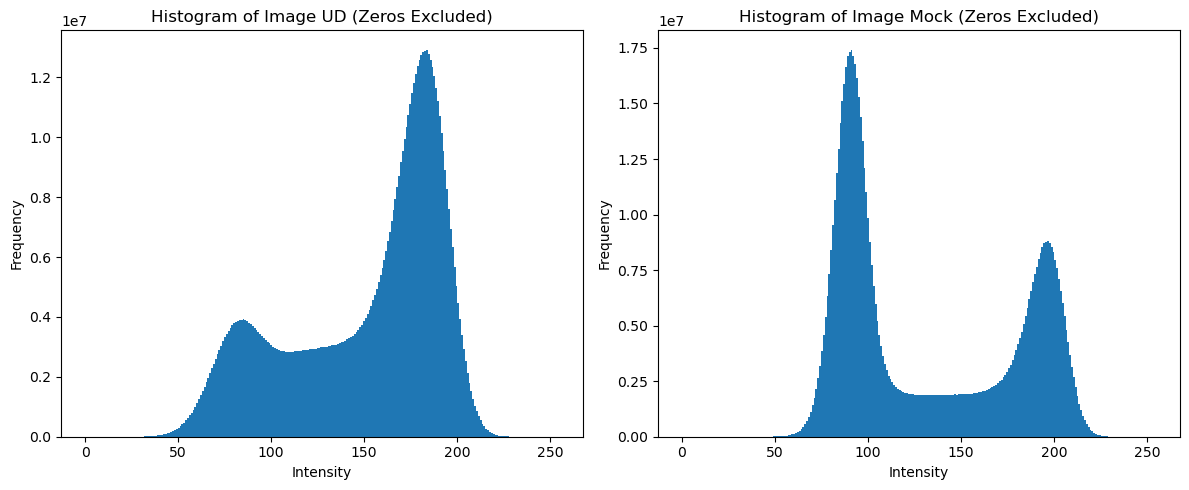

UD data: 751783458 non-zero pixels (75.19% of total)
Mock data: 752478756 non-zero pixels (75.26% of total)


In [ ]:
# Create histograms excluding zeros
plt.figure(figsize=(12, 5))

# Filter out zeros for UD data
nonzero_UD = tif_data_UD_norm.ravel()[tif_data_UD_norm.ravel() > 0]
plt.subplot(1, 2, 1)
plt.hist(nonzero_UD, bins=256, range=(0, 255))
plt.title("Histogram of Image UD (Zeros Excluded)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

# Filter out zeros for Mock data
nonzero_Mock = tif_data_Mock_norm.ravel()[tif_data_Mock_norm.ravel() > 0]
plt.subplot(1, 2, 2)
plt.hist(nonzero_Mock, bins=256, range=(0, 255))
plt.title("Histogram of Image Mock (Zeros Excluded)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print statistics about non-zero values
print(f"UD data: {len(nonzero_UD)} non-zero pixels ({len(nonzero_UD)/tif_data_UD_norm.size*100:.2f}% of total)")
print(f"Mock data: {len(nonzero_Mock)} non-zero pixels ({len(nonzero_Mock)/tif_data_Mock_norm.size*100:.2f}% of total)")